In [35]:
!pip install opencv-python-headless pytesseract easyocr paddleocr paddlepaddle

# **Import Modules**

In [51]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import pytesseract
import easyocr
import shutil

from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
from scipy.spatial import distance
from scipy.signal import wiener

# **Dataset**

In [37]:
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

In [38]:
images = []
annotations = []

for root, dirs, files in os.walk(path):
    for file in files:
      if file.endswith(".png"):
        images.append(os.path.join(root, file))
      elif file.endswith(".xml"):
        annotations.append(os.path.join(root, file))

In [39]:
images_annot = []

for image in images:
  for annotation in annotations:
    if image.split('/')[-1].split('.')[0] == annotation.split('/')[-1].split('.')[0]:
      images_annot.append((image, annotation))

# **Data Overview**

In [40]:
tree = ET.parse(images_annot[1][1])
root = tree.getroot()

In [41]:
def print_all_elements(element, indent=0):
    for child in element:
        print("  " * indent + f"{child.tag}: {child.text.strip() if child.text else ''}")
        print_all_elements(child, indent + 1)

print_all_elements(root)

folder: images
filename: Cars406.png
size: 
  width: 600
  height: 411
  depth: 3
segmented: 0
object: 
  name: licence
  pose: Unspecified
  truncated: 0
  occluded: 0
  difficult: 0
  bndbox: 
    xmin: 285
    ymin: 185
    xmax: 374
    ymax: 226


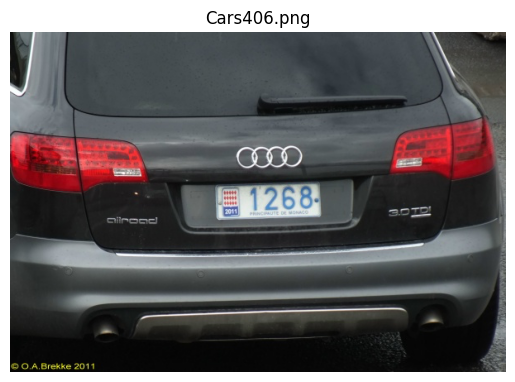

In [42]:
image = mpimg.imread(images_annot[1][0])
xmin, ymin = 274, 115
xmax, ymax = 343, 138
image_name = images_annot[1][0].split('/')[-1]

fig, ax = plt.subplots()
ax.imshow(image)
plt.axis('off')
plt.title(image_name)
plt.show()

# **Deskew**

In [43]:
def get_x_y(annotation):
    tree = ET.parse(annotation)
    root = tree.getroot()

    xmax = root.find(".//object/bndbox/xmax").text
    xmin = root.find(".//object/bndbox/xmin").text
    ymax = root.find(".//object/bndbox/ymax").text
    ymin = root.find(".//object/bndbox/ymin").text

    return int(xmax), int(xmin), int(ymax), int(ymin)

def xy_to_upperbottom(xmax, xmin, ymax, ymin):
    upper_left = (xmin, ymin)
    upper_right = (xmax, ymin)
    bottom_left = (xmin, ymax)
    bottom_right = (xmax, ymax)

    return upper_left, upper_right, bottom_left, bottom_right

def deskew_image(image_path, annotation_path):
    skewed = np.array(Image.open(image_path).convert('RGB'))

    xmax, xmin, ymax, ymin = get_x_y(annotation_path)
    upper_left, upper_right, bottom_left, bottom_right = xy_to_upperbottom(xmax, xmin, ymax, ymin)
    marks = np.array([upper_left, upper_right, bottom_left, bottom_right])

    h = round(distance.euclidean(upper_left, bottom_left))
    w = round(distance.euclidean(upper_left, upper_right))

    dst_corners = np.float32([(0, 0), (w, 0), (0, h), (w, h)])

    M = cv2.getPerspectiveTransform(marks.astype('float32'), dst_corners)
    deskew = cv2.warpPerspective(skewed, M, (w, h))

    return deskew

deskewed_image = deskew_image(images_annot[1][0], images_annot[1][1])

# **Denoising**

In [44]:
def denoise_image(image):
    denoised = cv2.bilateralFilter(image, 9, 75, 75)

    kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

    sharpened = cv2.filter2D(denoised, -1, kernel)

    sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(sharpened)

    return enhanced_img

def denoise_image_fastNlMeans(image):
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=5, searchWindowSize=21)

    return denoised_image

denoised = denoise_image_fastNlMeans(deskewed_image)

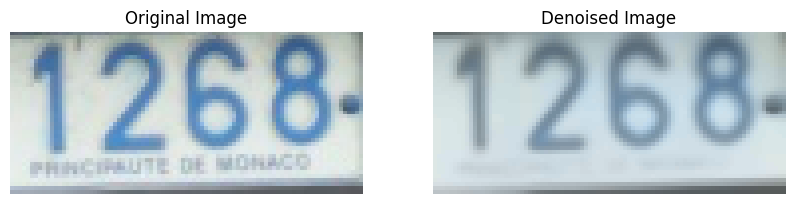

In [45]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(deskewed_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(denoised)
plt.axis('off')

plt.show()

# **Binarization**

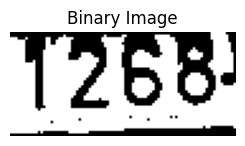

In [49]:
def binarization(image):
    img = denoised

    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    return binary_img

def otsu_thresholding_binary(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, otsu_thresholding = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return otsu_thresholding

binary_img = otsu_thresholding_binary(deskewed_image)

plt.subplot(1, 2, 2)
plt.title('Binary Image')
plt.imshow(binary_img, cmap='gray')
plt.axis('off')

plt.show()

# **Optical Character Recognition**

## **EasyOCR**

In [30]:
reader = easyocr.Reader(['en'])

def read_lisence(image):
    result = reader.readtext(image)

    for detection in result:
      print(f"Text: {detection[1]}, Confidence: {detection[2]}")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [33]:
read_lisence(deskewed_image)

Text: 1268, Confidence: 0.9971861243247986


In [31]:
read_lisence(denoised)

Text: 1268, Confidence: 0.6642736225528555


In [50]:
read_lisence(binary_img)

Text: 1268, Confidence: 0.7780690789222717


# **PaddleOCR**

In [52]:
def paddle_read_license(image):
    ocr = PaddleOCR(use_angle_cls=True, lang='en')

    result = ocr.ocr(image, cls=True)

    for line in result:
        for word in line:
            text, confidence = word[1]
            print(f'Text: {text}, Confidence: {confidence:.2f}')

In [53]:
paddle_read_license(deskewed_image)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:16<00:00, 237.83it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:05<00:00, 1868.05it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:09<00:00, 231.03it/s]

[2024/12/24 18:06:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

[2024/12/24 18:06:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24546265602111816
[2024/12/24 18:06:07] ppocr DEBUG: cls num  : 1, elapsed : 0.046681880950927734
[2024/12/24 18:06:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1825718879699707
Text: 1268, Confidence: 1.00


In [54]:
paddle_read_license(denoised)

[2024/12/24 18:20:18] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [55]:
paddle_read_license(binary_img)

[2024/12/24 18:20:28] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c